# 딥러닝에서 실행 속도를 더 빠르게 하는 방법

지금까지는 CPU를 사용했는데 GPU를 사용하면 딥러닝의 연산속도를 대폭 향상시킬 수 있습니다!

[런타임] - [런타임 유형 변경] - 하드웨어 가속기 GPU 선택 저장

# 데이터셋 다운로드

과일 사진 데이터셋

https://www.kaggle.com/moltean/fruits

In [ ]:
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
 98% 1.25G/1.28G [00:08<00:00, 134MB/s]
100% 1.28G/1.28G [00:08<00:00, 156MB/s]


In [ ]:
!unzip -q fruits.zip

# 패키지 로드

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 이미지 증강 기법

이번에는 `flow_from_directory` 메소드를 사용하여 데이터셋이 저장된 폴더에서 직접 데이터를 읽어오겠습니다!

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)

train_gen = train_datagen.flow_from_directory(
  'fruits-360_dataset/fruits-360/Training',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'fruits-360_dataset/fruits-360/Test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
from pprint import pprint
pprint(train_gen.class_indices)

{'Apple Braeburn': 0,
 'Apple Crimson Snow': 1,
 'Apple Golden 1': 2,
 'Apple Golden 2': 3,
 'Apple Golden 3': 4,
 'Apple Granny Smith': 5,
 'Apple Pink Lady': 6,
 'Apple Red 1': 7,
 'Apple Red 2': 8,
 'Apple Red 3': 9,
 'Apple Red Delicious': 10,
 'Apple Red Yellow 1': 11,
 'Apple Red Yellow 2': 12,
 'Apricot': 13,
 'Avocado': 14,
 'Avocado ripe': 15,
 'Banana': 16,
 'Banana Lady Finger': 17,
 'Banana Red': 18,
 'Beetroot': 19,
 'Blueberry': 20,
 'Cactus fruit': 21,
 'Cantaloupe 1': 22,
 'Cantaloupe 2': 23,
 'Carambula': 24,
 'Cauliflower': 25,
 'Cherry 1': 26,
 'Cherry 2': 27,
 'Cherry Rainier': 28,
 'Cherry Wax Black': 29,
 'Cherry Wax Red': 30,
 'Cherry Wax Yellow': 31,
 'Chestnut': 32,
 'Clementine': 33,
 'Cocos': 34,
 'Corn': 35,
 'Corn Husk': 36,
 'Cucumber Ripe': 37,
 'Cucumber Ripe 2': 38,
 'Dates': 39,
 'Eggplant': 40,
 'Fig': 41,
 'Ginger Root': 42,
 'Granadilla': 43,
 'Grape Blue': 44,
 'Grape Pink': 45,
 'Grape White': 46,
 'Grape White 2': 47,
 'Grape White 3': 48,
 'Grap

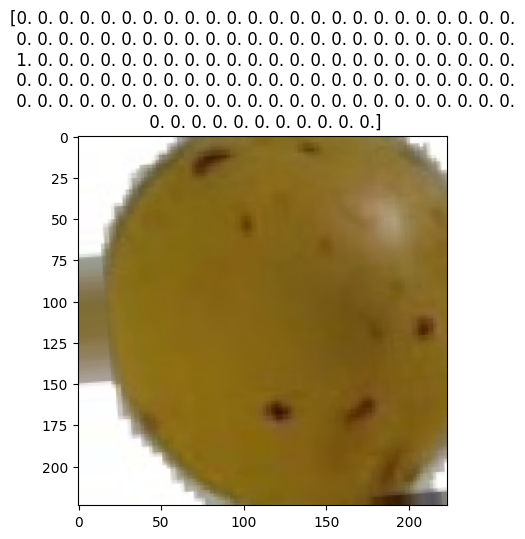

In [ ]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[0]))
plt.imshow(preview_imgs[0])

# 전이 학습

https://keras.io/api/applications/

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input = Input(shape=(224, 224, 3))

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(131, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

# 학습

`ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)`

`val_acc`가 높은 1개의 모델(save_best_only)을 model.h5 라는 파일로 저장한다.

https://keras.io/api/callbacks/model_checkpoint/

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=20, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

Epoch 1/20
2116/2116 [==============================] - ETA: 0s - loss: 0.7795 - acc: 0.7932
Epoch 1: val_acc improved from -inf to 0.72761, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2116/2116 [==============================] - 753s 336ms/step - loss: 0.7795 - acc: 0.7932 - val_loss: 1.1547 - val_acc: 0.7276
Epoch 2/20
2116/2116 [==============================] - ETA: 0s - loss: 0.1603 - acc: 0.9525
Epoch 2: val_acc improved from 0.72761 to 0.93697, saving model to model.h5
2116/2116 [==============================] - 704s 333ms/step - loss: 0.1603 - acc: 0.9525 - val_loss: 0.2416 - val_acc: 0.9370
Epoch 3/20
2116/2116 [==============================] - ETA: 0s - loss: 0.1090 - acc: 0.9683
Epoch 3: val_acc did not improve from 0.93697
2116/2116 [==============================] - 713s 337ms/step - loss: 0.1090 - acc: 0.9683 - val_loss: 0.3726 - val_acc: 0.9035
Epoch 4/20
2116/2116 [==============================] - ETA: 0s - loss: 0.0828 - acc: 0.9759
Epoch 4: val_acc did not improve from 0.93697
2116/2116 [==============================] - 705s 333ms/step - loss: 0.0828 - acc: 0.9759 - val_loss: 5.0733 - val_acc: 0.4167
Epoch 5/20
2116/2116 [=======================

# 학습 결과 그래프

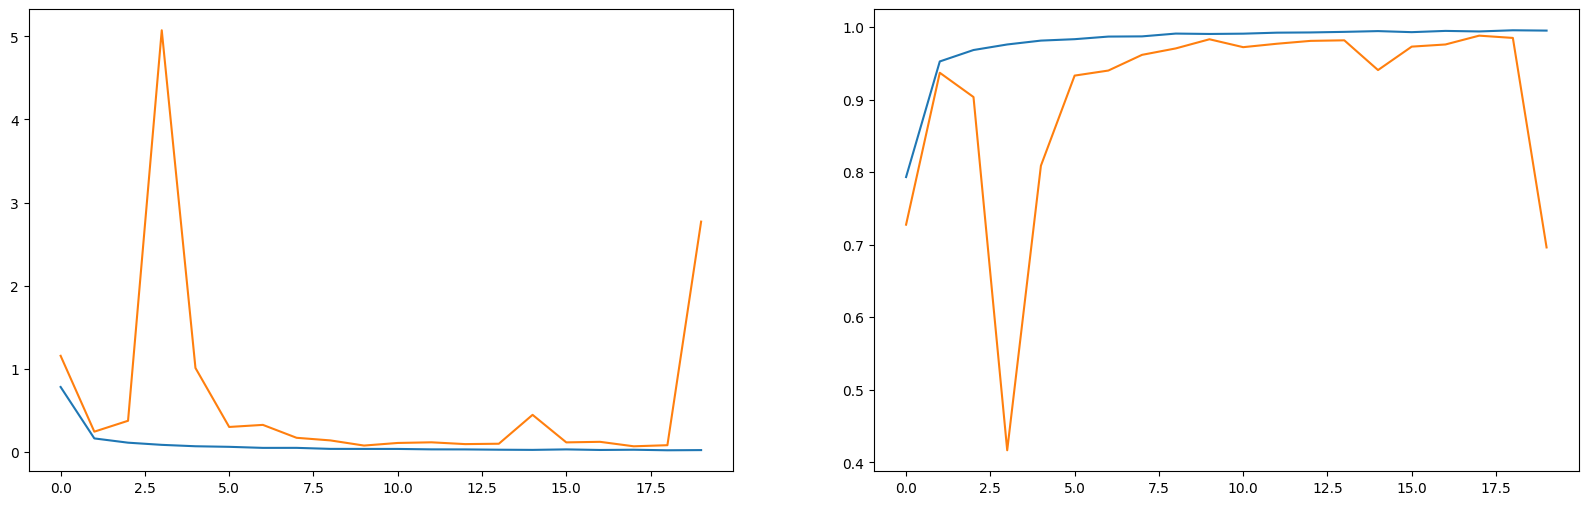

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

# 학습된 모델 로드

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


# 테스트

1/1 [==============================] - 1s 1s/step


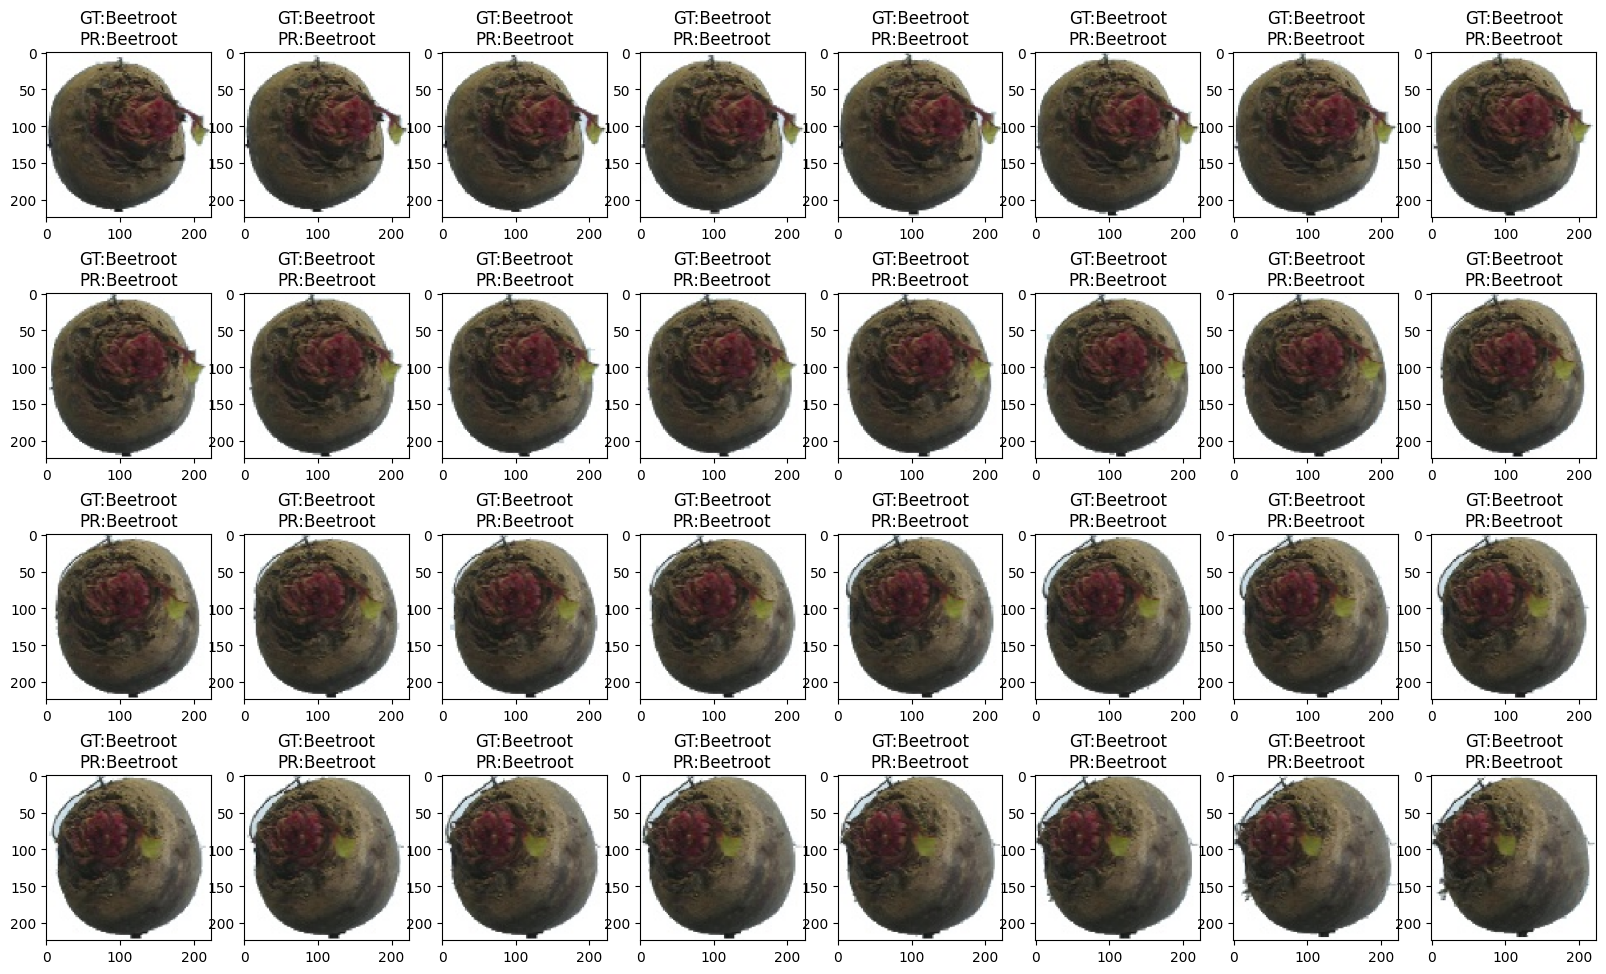

In [ ]:
test_imgs, test_labels = test_gen.__getitem__(100)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)